In [ ]:
# default_exp data.tsdataset

In [ ]:
#hide
from nbdev import *
%load_ext autoreload
%autoreload 2

## Base Dataset
> Transforms pandas DataFrame into a TimeSeriesDataset for the Dataloder.

In [ ]:
#export
import gc
import logging
from typing import Dict, List, Optional, Tuple, Union
from typing_extensions import Literal

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch
from torch.utils.data import Dataset

In [ ]:
#export
class BaseDataset(Dataset):
    """
    A class used to store Time Series data.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False,
                 input_size: int = None,
                 output_size: int = None,
                 complete_windows: bool = True,
                 verbose: bool = False) -> 'BaseDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        complete_windows: bool
            Whether consider only windows with available window_size.
            Default False.
        verbose: bool
            Wheter or not log outputs.
        """        
        assert type(Y_df) == pd.core.frame.DataFrame
        assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])
        self.verbose = verbose

        if X_df is not None:
            assert type(X_df) == pd.core.frame.DataFrame
            assert all([(col in X_df) for col in ['unique_id', 'ds']])
            assert len(Y_df)==len(X_df), 'The dimensions of Y_df and X_df are not the same'

        if mask_df is not None:
            assert len(Y_df)==len(mask_df), 'The dimensions of Y_df and mask_df are not the same'
            assert all([(col in mask_df) for col in ['unique_id', 'ds', 'sample_mask']])
            if 'available_mask' not in mask_df.columns:
                if self.verbose: 
                    logging.info('Available mask not provided, defaulted with 1s.')
                mask_df['available_mask'] = 1
            assert np.sum(np.isnan(mask_df.available_mask.values)) == 0
            assert np.sum(np.isnan(mask_df.sample_mask.values)) == 0
        else:
            mask_df = get_default_mask_df(Y_df=Y_df, 
                                          is_test=is_test,
                                          ds_in_test=ds_in_test)
        
        n_ds  = len(mask_df)
        n_avl = mask_df.available_mask.sum()        
        n_ins = mask_df.sample_mask.sum()
        n_out = len(mask_df) - mask_df.sample_mask.sum()

        avl_prc = np.round((100 * n_avl) / n_ds, 2)
        ins_prc = np.round((100 * n_ins) / n_ds, 2)
        out_prc = np.round((100 * n_out) / n_ds, 2)
        if self.verbose:
            logging.info('Train Validation splits\n')
            if len(mask_df.unique_id.unique()) < 10:
                logging.info(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
            else:
                logging.info(mask_df.groupby(['sample_mask']).agg({'ds': ['min', 'max']}))
            dataset_info  = f'\nTotal data \t\t\t{n_ds} time stamps \n'
            dataset_info += f'Available percentage={avl_prc}, \t{n_avl} time stamps \n'
            dataset_info += f'Insample  percentage={ins_prc}, \t{n_ins} time stamps \n'
            dataset_info += f'Outsample percentage={out_prc}, \t{n_out} time stamps \n'
            logging.info(dataset_info)
 
        self.ts_data, self.s_matrix, self.meta_data, self.t_cols, self.s_cols \
                         = self._df_to_lists(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df)

        # Dataset attributes
        self.n_series = len(self.ts_data)
        self.max_len = max([len(ts) for ts in self.ts_data])
        self.n_channels = len(self.t_cols) # t_cols insample_mask and outsample_mask
        self.frequency = pd.infer_freq(Y_df.head()['ds'])
        self.f_cols = f_cols
        self.f_idxs = self._get_f_idxs(f_cols) if f_cols else []
        self.input_size = input_size
        self.output_size = output_size
        self.complete_windows = complete_windows
        self.first_ds = 0

        # Number of X and S features
        self.n_x = 0 if X_df is None else X_df.shape[1] - 2 # -2 for unique_id and ds
        self.n_s = 0 if S_df is None else S_df.shape[1] - 1 # -1 for unique_id

        # Balances panel and creates 
        # numpy  s_matrix of shape (n_series, n_s)
        # numpy ts_tensor of shape (n_series, n_channels, max_len) n_channels = t_cols + masks
        self.len_series, self.ts_tensor = self._create_tensor()
        
        # Defining sampleable time series
        self.ts_idxs = np.arange(self.n_series)
        self.sampleable_ts_idxs: np.ndarray
        self.n_sampleable_ts: int
            
        self._define_sampleable_ts_idxs()

In [ ]:
#export
@patch
def _define_sampleable_ts_idxs(self: BaseDataset):
    self.n_sampleable_ts = len(self.ts_tensor)
    self.sampleable_ts_idxs = self.ts_idxs.copy()

In [ ]:
#export
@patch
def _df_to_lists(self: BaseDataset, 
                 S_df: pd.DataFrame,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame, 
                 mask_df: pd.DataFrame) -> Tuple[List[np.ndarray], 
                                                 List[np.ndarray],
                                                 List[np.ndarray], 
                                                 List[str],
                                                 List[str]]:
    """Transforms input dataframes to lists.

    Parameters
    ----------
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds'] 
        and static variables.    
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y'].
    mask_df: pd.DataFrame
        Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
        and optionally 'available_mask'.
        Default None: constructs default mask based on ds_in_test.

    Returns
    -------
    Tuple of five lists:
        - List of time series. Each element of the list is a 
          numpy array of shape (length of the time series, n_channels),
          where n_channels = t_cols + masks.
        - List of static variables. Each element of the list is a 
          numpy array of shape (1, n_s).
          where n_channels = t_cols + masks.
        - List of meta data. Each element of the list is a 
          numpy array of shape (lenght of the time series, 2) 
          and corresponds to unique_id, ds.
        - List of temporal variables (including target and masks). 
        - List of statitc variables.
    """
    # None protections
    if X_df is None:
        X_df = Y_df[['unique_id', 'ds']]
    
    if S_df is None:
        S_df = Y_df[['unique_id']].drop_duplicates()
    
    # Protect order of data
    Y = Y_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    X = X_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    M = mask_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    
    assert np.array_equal(X.unique_id.values, Y.unique_id.values), f'Mismatch in X, Y unique_ids'
    assert np.array_equal(X.ds.values, Y.ds.values), f'Mismatch in X, Y ds'
    assert np.array_equal(M.unique_id.values, Y.unique_id.values), f'Mismatch in M, Y unique_ids'
    assert np.array_equal(M.ds.values, Y.ds.values), f'Mismatch in M, Y ds'
    
    # Create bigger grouped by dataframe G to parse
    M = M[['available_mask', 'sample_mask']]
    X.drop(['unique_id', 'ds'], 1, inplace=True)
    G = Y.join(X).join(M)
    
    S = S_df.sort_values('unique_id')
    
    # time columns and static columns for future indexing
    t_cols = list(G.columns[2:]) # avoid unique_id and ds
    s_cols = list(S.columns[1:]) # avoid unique_id
    
    grouped = G.groupby('unique_id')
    meta = G[['unique_id', 'ds']].values
    data = G.drop(columns=['unique_id', 'ds']).values
    sizes = grouped.size()
    idxs = np.append(0, sizes.cumsum())
    ts_data = []
    meta_data = []
    for start, end in zip(idxs[:-1], idxs[1:]):
        ts_data.append(data[start:end])
        meta_data.append(meta[start:end])
        
    if S['unique_id'].value_counts().max() > 1:
        raise ValueError('Found duplicated unique_ids in S_df')
    s_data = S.drop(columns='unique_id').values
    
    del S, Y, X, M, G
    gc.collect()
    
    return ts_data, s_data, meta_data, t_cols, s_cols

In [ ]:
# export
@patch
def _create_tensor(self: BaseDataset) -> Tuple[np.array, t.Tensor]:
    """Transforms outputs from self._df_to_lists to numpy arrays."""
    ts_tensor = np.zeros((self.n_series, self.n_channels, self.max_len))

    len_series = np.empty(self.n_series, dtype=np.int32)
    for idx, ts_idx in enumerate(self.ts_data):
        # Left padded time series tensor
        ts_tensor[idx, :, -ts_idx.shape[0]:] = ts_idx.T
        len_series[idx] = ts_idx.shape[0]
    
    ts_tensor = t.Tensor(ts_tensor)

    return len_series, ts_tensor

In [ ]:
#export
@patch
def _get_f_idxs(self: BaseDataset, 
               cols: List[str]) -> List:
    """Gets indexes of exogenous variables.

    Parameters
    ----------
    cols: List[str]
        Interest exogenous variables.

    Returns
    -------
    Indexes of cols variables.
    """
    # Check if cols are available f_cols and return the idxs
    if not all(col in self.f_cols for col in cols):
        str_cols = ', '.join(cols)
        raise Exception(f'Some variables in {str_cols} are not available in f_cols.')
    
    f_idxs = [self.t_cols.index(col) for col in cols]

    return f_idxs

In [ ]:
#export
@patch
def __getitem__(self: BaseDataset, 
                idx: Union[slice, int]) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    pass

In [ ]:
#export
@patch
def __len__(self: BaseDataset):
    return self.n_series

In [ ]:
#export
@patch
def get_n_variables(self: BaseDataset) -> Tuple[int, int]:
    """Gets number of exogenous and static variables."""
    return self.n_x, self.n_s

@patch
def get_n_series(self: BaseDataset) -> int:
    """Gets number of time series."""
    return self.n_series

@patch
def get_max_len(self: BaseDataset) -> int:
    """Gets max len of time series."""
    return self.max_len

@patch
def get_n_channels(self: BaseDataset) -> int:
    """Gets number of channels considered."""
    return self.n_channels

@patch
def get_frequency(self: BaseDataset) -> str:
    """Gets infered frequency."""
    return self.frequency

In [ ]:
#export
def get_default_mask_df(Y_df: pd.DataFrame, 
                        ds_in_test: int, 
                        is_test: bool) -> pd.DataFrame:
    """Constructs default mask df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_test: int
        Numer of datestamps to use as outsample.
    is_test: bool
        Wheter target time series belongs to test set.

    Returns
    -------
    Mask DataFrame with columns 
    ['unique_id', 'ds', 'available_mask', 'sample_mask'].
    """
    mask_df = Y_df[['unique_id', 'ds']].copy()
    mask_df['available_mask'] = 1
    mask_df['sample_mask'] = 1
    mask_df = mask_df.set_index(['unique_id', 'ds'])
    
    mask_df_s = mask_df.sort_values(by=['unique_id', 'ds'])
    zero_idx = mask_df_s.groupby('unique_id').tail(ds_in_test).index
    mask_df.loc[zero_idx, 'sample_mask'] = 0
    mask_df = mask_df.reset_index()
    mask_df.index = Y_df.index

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

# TimeSeries Dataset

In [ ]:
#export
class TimeSeriesDataset(BaseDataset):
    """
    A class used to store Time Series data.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 input_size: int,
                 output_size: int,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False, 
                 complete_windows: bool = True,
                 verbose: bool = False) -> 'TimeSeriesDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        verbose: bool
            Wheter or not log outputs.
        """        
        super(TimeSeriesDataset, self).__init__(Y_df=Y_df, input_size=input_size,
                                                output_size=output_size,
                                                X_df=X_df, S_df=S_df, f_cols=f_cols,
                                                mask_df=mask_df, ds_in_test=ds_in_test,
                                                is_test=is_test, complete_windows=complete_windows,
                                                verbose=verbose)

In [ ]:
#export
@patch
def __getitem__(self: TimeSeriesDataset, 
                idx: Union[slice, int]) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    if isinstance(idx, int):
        idx = [idx]
    elif isinstance(idx, slice) or isinstance(idx, list):
        pass
    else:
        raise Exception('Use slices, int or list for getitem.')

    # Parse windows to elements of batch
    S = t.Tensor(self.s_matrix[idx])
    Y = self.ts_tensor[idx, self.t_cols.index('y'), :]
    X = self.ts_tensor[idx, (self.t_cols.index('y') + 1):self.t_cols.index('available_mask'), :]
    
    available_mask = self.ts_tensor[idx, self.t_cols.index('available_mask'), :]
    sample_mask = self.ts_tensor[idx, self.t_cols.index('sample_mask'), :]
    ts_idxs = t.as_tensor(idx, dtype=t.long)

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'idxs': ts_idxs}
    
    return batch

# Windows Dataset

In [ ]:
#export
class WindowsDataset(BaseDataset):
    """
    A class used to store Time Series data.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 input_size: int,
                 output_size: int,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False,
                 sample_freq: int = 1,
                 complete_windows: bool = True,
                 last_window: bool = False,
                 verbose: bool = False) -> 'TimeSeriesDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        last_window: bool
            Only used for forecast (test)
            Wheter the dataset will include only last window for each time serie.
        verbose: bool
            Wheter or not log outputs.
        """        
        super(WindowsDataset, self).__init__(Y_df=Y_df, input_size=input_size,
                                             output_size=output_size,
                                             X_df=X_df, S_df=S_df, f_cols=f_cols,
                                             mask_df=mask_df, ds_in_test=ds_in_test,
                                             is_test=is_test, complete_windows=complete_windows,
                                             verbose=verbose)
        # WindowsDataset parameters
        self.windows_size = self.input_size + self.output_size
        self.padding = (self.input_size, self.output_size)
        self.sample_freq = sample_freq
        self.last_window = last_window

In [ ]:
#export
@patch
def _create_windows_tensor(self: WindowsDataset, 
                           idx: slice) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
    """Creates windows of size windows_size from
    the ts_tensor of the TimeSeriesDataset filtered by
    window_sampling_limit and ts_idxs. The step of each window
    is defined by idx_to_sample_freq.
    
    Parameters
    ----------
    index: slice
        Indexes of time series to consider.
    
    Returns
    -------
    Tuple of three elements:
        - Windows tensor of shape (windows, channels, input_size + output_size)
        - Static variables tensor of shape (windows * series, n_static)
        - Time Series indexes for each window.
    """
    # Default ts_idxs=ts_idxs sends all the data, otherwise filters series   
    tensor = self.ts_tensor[idx, :, self.first_ds:]

    padder = t.nn.ConstantPad1d(padding=self.padding, value=0)
    tensor = padder(tensor)

    # Creating rolling windows and 'flattens' them
    windows = tensor.unfold(dimension=-1, 
                            size=self.windows_size, 
                            step=self.sample_freq)
    # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
    windows = windows.permute(0, 2, 1, 3)
    windows = windows.reshape(-1, self.n_channels, self.windows_size)
    
    # Broadcast s_matrix: This works because unfold in windows_tensor, orders: serie, time
    
    ts_idxs = self.ts_idxs[idx]
    n_ts = len(ts_idxs)
    windows_per_serie = len(windows) / n_ts
    
    ts_idxs = ts_idxs.repeat(repeats=windows_per_serie)
    s_matrix = self.s_matrix[idx]
    s_matrix = s_matrix.repeat(repeats=windows_per_serie, axis=0)
    
    s_matrix = t.Tensor(s_matrix)
    ts_idxs = t.as_tensor(ts_idxs, dtype=t.long)

    windows_idxs = self._get_sampleable_windows_idxs(ts_windows_flatten=windows,
                                                     ts_idxs=ts_idxs)

    # Raise error if nothing to sample from
    if not windows_idxs.size:
        raise Exception(
            f'Time Series {idx} are not sampleable. '
            'Check the data, masks, window_sampling_limit, '
            'input_size, output_size, masks.'
        )

    # Index the windows and s_matrix tensors of batch
    windows = windows[windows_idxs]
    s_matrix = s_matrix[windows_idxs]
    ts_idxs = ts_idxs[windows_idxs]

    return windows, s_matrix, ts_idxs

In [ ]:
#export
@patch
#TODO: do we want complete? inputs seems irrelevant, NBEATS dont use it, for now is our only model
def _get_sampleable_windows_idxs(self: WindowsDataset, 
                                 ts_windows_flatten: t.Tensor,
                                 ts_idxs: t.Tensor) -> np.ndarray:
    """Gets indexes of windows that fulfills conditions.
    
    Parameters
    ----------
    ts_windows_flatten: t.Tensor
        Tensor of shape (windows, n_channels, windows_size)
    
    Returns
    -------
    Numpy array of indexes of ts_windows_flatten that 
    fulfills conditions.
    
    Notes
    -----
    """

    if self.last_window:
        _, idxs_counts = t.unique(ts_idxs, return_counts=True)
        last_idxs = idxs_counts.cumsum(0) - 1
        last_idxs = last_idxs.numpy()

        return last_idxs

    else:
        sample_condition = ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:]
        sample_condition = t.sum(sample_condition, axis=1)
        sample_condition = (sample_condition > 0) * 1           
        sampling_idx = t.nonzero(sample_condition > 0)
        sampling_idx = sampling_idx.flatten().numpy()
        
        return sampling_idx

In [ ]:
#export
@patch
def __getitem__(self: WindowsDataset, 
                idx: Union[slice, int]) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    if isinstance(idx, int):
        idx = [idx]
    elif isinstance(idx, slice) or isinstance(idx, list):
        pass
    else:
        raise Exception('Use slices, int or list for getitem.')

    # Create windows for each sampled ts and sample random unmasked windows from each ts
    windows, S, ts_idxs = self._create_windows_tensor(idx=idx)

    # Parse windows to elements of batch
    Y = windows[:, self.t_cols.index('y'), :]
    X = windows[:, (self.t_cols.index('y') + 1):self.t_cols.index('available_mask'), :]
    available_mask = windows[:, self.t_cols.index('available_mask'), :]
    sample_mask = windows[:, self.t_cols.index('sample_mask'), :]

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'idxs': ts_idxs}
    
    return batch

## Default mask example and tests

In [ ]:
def test_default_mask(Y_df, ds_in_test, is_test):
    mask_df = get_default_mask_df(Y_df, ds_in_test, is_test)
    assert Y_df.index.equals(mask_df.index), 'Unmatching index bewteen Y_df and mask_df'
    
    for uid, df in mask_df.groupby('unique_id'):
        len_ts = df.shape[0]
        expected_sample_mask = np.ones(len_ts)
        expected_sample_mask[-ds_in_test:] = 0
        if is_test: 
            expected_sample_mask = 1 - expected_sample_mask
        expected_available_mask = np.ones(len_ts)
        
        sample_mask = df['sample_mask'].values
        available_mask = df['available_mask'].values
        
        assert np.array_equal(sample_mask, expected_sample_mask), (
            f'Error for sample mask for time series {uid}'
        )
        
        assert np.array_equal(available_mask, expected_available_mask), (
            f'Error for available mask for time series {uid}'
        )

### Test for synthtetic time series data

In [ ]:
from nixtlats.data.utils import create_synthetic_tsdata

Y_df, X_df, S_df = create_synthetic_tsdata()
ds_in_test = 2
is_test = False
test_default_mask(Y_df, ds_in_test, is_test)
test_default_mask(Y_df, ds_in_test, True)

### Example and test for datasets with two time series

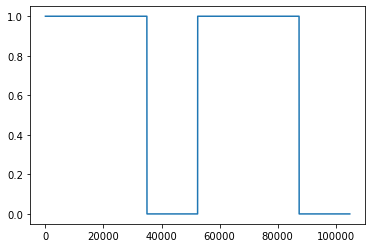

In [ ]:
import matplotlib.pyplot as plt

from nixtlats.data.datasets.epf import EPF, EPFInfo

Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=['NP', 'PJM'])
test_default_mask(Y_df, ds_in_test=728 * 24, is_test=False)
mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728 * 24, is_test=False)

plt.plot(mask_df.sample_mask.values)

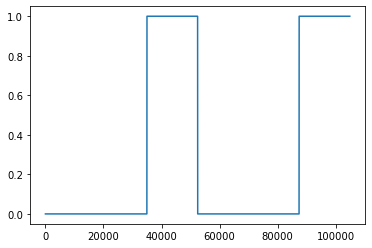

In [ ]:
mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728 * 24, is_test=True)

plt.plot(mask_df.sample_mask.values)

### Test for datasets with more than two time series

In [ ]:
from nixtlats.data.datasets.tourism import Tourism, TourismInfo

meta = TourismInfo['Yearly']
Y_df, *_ = Tourism.load(directory='data', group=meta.name)
test_default_mask(Y_df, ds_in_test=meta.horizon, is_test=False)
test_default_mask(Y_df, ds_in_test=meta.horizon, is_test=True)

## Dataset tests

In [ ]:
def instantiate_datasets(Y_df, S_df, X_df, f_cols=None, 
                         ds_in_test=0, is_test=False,
                         input_size=15,
                         output_size=1,
                         complete_windows=False,
                         sample_freq=1):
    mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=ds_in_test, is_test=is_test)
                        
    ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=X_df, f_cols=f_cols, 
                                   mask_df=mask_df,
                                   input_size=input_size,
                                   output_size=output_size,
                                   complete_windows=complete_windows)
    
    wd_dataset = WindowsDataset(Y_df=Y_df, S_df=S_df, X_df=X_df, f_cols=f_cols, 
                                   mask_df=mask_df,
                                   input_size=input_size,
                                   output_size=output_size,
                                   sample_freq=sample_freq,
                                   complete_windows=complete_windows)
    
    return ts_dataset, wd_dataset, mask_df

In [ ]:
def test_dataset_attrs(Y_df, S_df, X_df, f_cols, ds_in_test, is_test):
    # This set catches mistmaches between Y_df and ts_tensor
    ts_dataset, wd_dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                           f_cols=f_cols, ds_in_test=ds_in_test, 
                                           is_test=is_test)
    
    dfs = [Y_df, X_df, mask_df]
    dfs = [df.set_index(['unique_id', 'ds']) for df in dfs]
    dfs = dfs[0].join(dfs[1:])
    
    #Temporal variables
    for dataset in [ts_dataset, wd_dataset]:
        for idx_ts, (uid, df) in enumerate(dfs.groupby('unique_id')):
            len_ts = dataset.len_series[idx_ts]

            for col in dataset.t_cols:
                ts = t.Tensor(df[col].values)
                idx_tensor = dataset.t_cols.index(col)
                ts_tensor = dataset.ts_tensor[idx_ts, idx_tensor, -len_ts:]

                assert np.array_equal(ts, ts_tensor), (
                    f'Error with time series {uid} and col {col} (idx={idx_ts}).'
                )

        #Static variables
        for idx_ts, (uid, df) in enumerate(S_df.groupby('unique_id')):
            len_ts = dataset.len_series[idx_ts]

            s = df[dataset.s_cols].values
            s_matrix = dataset.s_matrix[[idx_ts]]

            assert np.array_equal(s, s_matrix), (
                f'Error with static variables for time series {uid} (idx={idx_ts})'
            )

In [ ]:
def test_get_f_idxs(Y_df, S_df, X_df, f_cols, ds_in_test, is_test, expected_f_idxs):
    ts_dataset, wd_dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                           f_cols=f_cols, ds_in_test=ds_in_test, 
                                           is_test=is_test)
    
    assert ts_dataset._get_f_idxs(f_cols) == expected_f_idxs
    assert wd_dataset._get_f_idxs(f_cols) == expected_f_idxs

In [ ]:
def test_ts_tensor(Y_df, S_df, X_df, f_cols, ds_in_test, is_test, 
                   input_size, output_size, ts_idxs):
    ts_dataset, wd_dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                           f_cols=f_cols, ds_in_test=ds_in_test, 
                                           is_test=is_test,
                                           input_size=input_size,
                                           output_size=output_size)
    
    for dataset in [ts_dataset, wd_dataset]:
        min_len = min(dataset.len_series)
        dfs = [Y_df, X_df, mask_df]
        dfs = [df.set_index(['unique_id', 'ds']) for df in dfs]
        dfs = dfs[0].join(dfs[1:])
        
        # This process only works for balanced datasets.
        
        n_ts = Y_df['unique_id'].unique().shape[0]
        n_x = dfs.columns.shape[0]
        idxs = range(n_ts) if ts_idxs is None else ts_idxs

        e_filtered_tensor = t.Tensor(dfs.values.reshape((n_ts, min_len, n_x))[idxs])
        e_filtered_tensor = np.swapaxes(e_filtered_tensor, 2, 1)
        filtered_tensor = dataset.ts_tensor[ts_idxs, :, dataset.first_ds:]

        assert np.array_equal(e_filtered_tensor, filtered_tensor), (
            "Expected and dataset filtered_tensor are different. Check."
        )

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

# This test only works for the synthetic dataset constructed 
# using create_synthetic_tsdata
# and for the 21 time series
def test_batch_construction_windows(Y_df, S_df, X_df, ds_in_test, 
                                    is_test, input_size, output_size, sample_freq, 
                                    ):
    """Test to verify that the batch (of windows) is well constructed."""

    _, dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                               ds_in_test=ds_in_test, is_test=is_test,
                                               input_size=input_size,
                                               output_size=output_size,
                                               sample_freq=sample_freq)
    
    windows_size = input_size + output_size
    max_len = Y_df.groupby('unique_id').size().max()
    
    windows = dataset[20]['Y'].numpy()
    
    #Expected windows
    uid = Y_df['unique_id'].unique()[20]
    Y_original = Y_df.query('unique_id == @uid')['y'].values
    size = Y_original.size
    Y_sample = np.zeros(max_len)
    Y_sample[-size:] = Y_original
    
    Y_sample = np.pad(Y_sample, (input_size+100, output_size))

    e_windows = sliding_window_view(Y_sample, window_shape=windows_size)
    e_windows = e_windows[0:-(ds_in_test+output_size-1):sample_freq] #-1 for at least one available sample

    # This test works assuming there are no series with all values of zero.
    sampleable_windows_idxs = np.where((e_windows > 0).sum(1) >= 1)[0]     
    e_windows = e_windows[sampleable_windows_idxs]
    
    #Comparison
    assert np.array_equal(windows, e_windows), (
        'Expected and actual windows are different'
    )

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

# This test only works for the synthetic dataset constructed 
# using create_synthetic_tsdata
# and for the 21 time series
def test_batch_construction_ts(Y_df, S_df, X_df, ds_in_test, 
                                    is_test, input_size, output_size, sample_freq, 
                                    ):
    """Test to verify that the batch (of windows) is well constructed."""

    dataset, _, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                               ds_in_test=ds_in_test, is_test=is_test,
                                               input_size=input_size,
                                               output_size=output_size,
                                               sample_freq=sample_freq)
    
    batch = dataset[20]['Y'].numpy()
    max_len = Y_df.groupby('unique_id').size().max()
    
    #Expected windows
    uid = Y_df['unique_id'].unique()[20]
    Y_original = Y_df.query('unique_id == @uid')['y'].values
    size = Y_original.size
    e_batch = np.zeros(max_len)
    e_batch[-size:] = Y_original
    e_batch = e_batch[None,:]

    #Comparison
    assert np.array_equal(batch, e_batch), (
        'Expected and actual windows are different'
    )

### Test for not sorted datasets with more than two time series

In [ ]:
from nixtlats.data.utils import create_synthetic_tsdata

Y_df, X_df, S_df = create_synthetic_tsdata()
ds_in_test = 2
is_test = False
f_cols = ['future_1']
expected_f_idxs = [2]
len_sample_chunks = 15 #only for ESRNN

In [ ]:
test_dataset_attrs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test)

In [ ]:
test_get_f_idxs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test, 
                expected_f_idxs=expected_f_idxs)

#### Expected error for non-sorted datasets 

For the `ts_tensor` attribute from the `dataset` and `Y_df` to have the same order it is necessary that `Y_df` is sorted by `unique_id` and `ds`. This test (expected error) proves that for unordered data the order is different.

In [ ]:
def _fail_non_sorted(): 
    test_ts_tensor(Y_df, S_df, X_df, f_cols=f_cols, 
                   ds_in_test=ds_in_test, 
                   is_test=is_test,
                   ts_idxs=[1, 0], 
                   output_size=ds_in_test)
test_fail(_fail_non_sorted)

#### Test using sorted synthtic ts data

In [ ]:
from nixtlats.data.utils import create_synthetic_tsdata

Y_df, X_df, S_df = create_synthetic_tsdata(sort=True)
ds_in_test = 2
is_test = False
f_cols = ['future_1']
expected_f_idxs = [2]
len_sample_chunks = 15 #only for ESRNN

In [ ]:
test_batch_construction_windows(Y_df, S_df, X_df, ds_in_test=ds_in_test,
                                is_test=is_test, input_size=5, output_size=2,
                                sample_freq=1)

In [ ]:
test_batch_construction_ts(Y_df, S_df, X_df, ds_in_test=ds_in_test,
                           is_test=is_test, input_size=5, output_size=2,
                           sample_freq=1)

### Test for already sorted datasets

In [ ]:
from nixtlats.data.datasets.epf import EPF, EPFInfo

Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=['NP', 'PJM'])
f_cols = ['Exogenous1', 'Exogenous2']
ds_in_test = 728 * 24
is_test = True
expected_f_idxs = [1, 2] #after y column

In [ ]:
test_dataset_attrs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test)

In [ ]:
test_ts_tensor(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test,
               input_size=ds_in_test, output_size=ds_in_test, ts_idxs=[1, 0])

In [ ]:
test_get_f_idxs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test, 
                expected_f_idxs=expected_f_idxs)

### Test for already sorted datasets with more than two time series

In [ ]:
from nixtlats.data.datasets.tourism import Tourism, TourismInfo

meta = TourismInfo['Yearly']
df, *_ = Tourism.load(directory='./data', group=meta.name)
df['day_of_week'] = df['ds'].dt.day_of_week
df['id_ts'] = df['unique_id'].astype('category').cat.codes

Y_df = df.filter(items=['unique_id', 'ds', 'y'])
X_df = df.filter(items=['unique_id', 'ds', 'day_of_week'])
S_df = df.filter(items=['unique_id', 'id_ts']).drop_duplicates().reset_index(drop=True)
Y_df = Y_df.groupby('unique_id').tail(11)
X_df = X_df.groupby('unique_id').tail(11)

In [ ]:
test_dataset_attrs(Y_df, S_df, X_df, f_cols=[], ds_in_test=meta.horizon, is_test=True)

In [ ]:
test_ts_tensor(Y_df, S_df, X_df, f_cols=[], ds_in_test=meta.horizon, is_test=False,
               input_size=5, 
               output_size=meta.horizon, ts_idxs=[1, 7, 10, 15])

In [ ]:
test_get_f_idxs(Y_df, S_df, X_df, f_cols=[], ds_in_test=ds_in_test, is_test=is_test, 
                expected_f_idxs=[])